<b>The problem:</b> given a node $x$ and a graph, find what community (group of nodes) the node $x$ belongs/most related to. <br>
<b>Random walk with restart (rwr):</b> random walk but each walk there's probability $p$ to restart and return to the initial node. <br>
<b>My approach:</b> using rwr (many times), we can get the most related node to node $x$ (node $y$). then we will perform rwr again, but now the walker can restart to node $x$ or node $y$, then we get the most related node to node $x$ and $y$. and so on, until we get the wanted community size.

To check if my algorithm works, I will apply the algorithm on wikipedia pages connections graph.

In [1]:
# import wikipedia
# import random
# import networkx as nx
# import pandas as pd
# import matplotlib.pyplot as plt
# import time
# import copy
# import csv
# from ast import literal_eval
# import pydot
# import igraph as ig

In [2]:
def bubble_sort_dict(dict_to_sort: dict) -> dict:
    dict_items = list(dict_to_sort.items())
    for i in range(len(dict_items)):
        for j in range(len(dict_items) - 1):
            if dict_items[j][1] < dict_items[j + 1][1]:
                dict_items[j], dict_items[j + 1] = dict_items[j + 1], dict_items[j]
    return dict(dict_items)

<b>wikipedia_graph_csv:</b> gets wiki page and creates a csv file containing wiki page links and their links also. 

In [3]:
import wikipedia
import csv 
import time #to avoid requasts limit

In [4]:
def wikipedia_graph_csv(source_page, file_name):
    with open(file_name, "w", newline='', encoding="utf-8") as file:
        writer = csv.writer(file)
        writer.writerow(['page', 'links'])
        page_links = wikipedia.page(source_page, auto_suggest=False).links
        writer.writerow([source_page, page_links])
        for page in page_links:
            try:
                writer.writerow([page, wikipedia.page(page, auto_suggest=False).links])
                time.sleep(1)
            except:
                pass

<b>csv_to_dict:</b> gets a csv file containing network graph, converting it to pandas df and then to dictionary.

In [5]:
import pandas as pd
from ast import literal_eval #the csv file saves the array (that contain each page links) as string, so this moudle will convert it to array

In [6]:
def csv_to_dict(file_name)-> dict:
    graph_df = pd.read_csv(file_name)
    for i in graph_df.index:
        graph_df.iloc[i, 1] = literal_eval(graph_df.iloc[i, 1])
    return graph_df.set_index('page').to_dict()['links']

<b>random_graph:</b> returns a random graph (in dictionary format). Useful for testing the algorithm.

In [7]:
import random

In [8]:
def random_graph(nodes_num, min_deg_out=0, max_deg_out=None, rnd_range=None)->dict:
    if max_deg_out==None:
        max_deg_out=nodes_num
    if rnd_range==None:
        rnd_range=nodes_num
    return {i: list(set(random.choices([k for k in range(rnd_range) if k!= i],k=random.randint(min_deg_out, max_deg_out)))) for i in range(nodes_num)}

# visualization of the graphs

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
import igraph as ig
import pydot #related to igraph libary

<b>networkx:</b> simple, can't display large graphs. <br>
<b>igraph:</b> not simple or convenient, but can display large graphs.

### displaying the wikipedia network graph (using iGraph)

In [447]:
wikipedia_graph_csv("numpy", "wiki_graph.csv")

In [10]:
numpy_wiki_graph = csv_to_dict("wiki_graph.csv")

In [11]:
#graph_dict = numpy_wiki_graph
# g = ig.Graph()
# g.add_vertices(list(set(list(graph_dict.keys()) + list([a for v in graph_dict.values() for a in v]))))
# g.add_edges([(v, a) for v in graph_dict.keys() for a in graph_dict[v]])
# ig.plot(g, 'numpy_graph.png')

<img src='numpy_graph.png' width=600 height=600>

note: shows only the connections between the source node links.

### displaying small graphs (using networkx

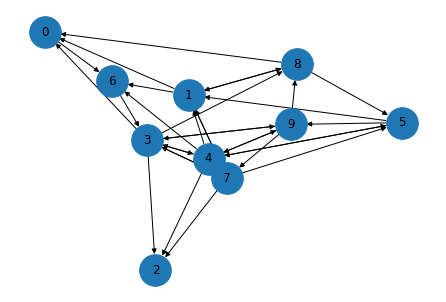

In [12]:
nx.draw(nx.DiGraph(random_graph(10)), with_labels=True, node_size=1000)

## filtering the graph
### rwr function shows better results if the graph is filtered
<b>filtered graph:</b> the graph will contain only the connections between the source page links. (nodes that the source page doesn't link to, will be deleted). <br>
Also if the node links to itself, the node will be deleted from the node links array. <br>
Also filters "identifier" pages for wiki page graph (since "identifier" pages are always showing in references in wikipedia)

In [13]:
import copy #to not overwrite the original graph

In [47]:
def filter_graph(graph:dict):
    filtered_graph = copy.deepcopy(graph)
    filter_identifiers = lambda node: "identifier" not in node[0]
    try: #if all dict keys are strings
        filtered_graph = dict(filter(filter_identifiers, list(filtered_graph.items())))
    except :
        pass
    is_key = lambda node: node in filtered_graph.keys() 
    for i in filtered_graph:
        filtered_graph[i] = list(filter(is_key, filtered_graph[i]))
    
    for node in filtered_graph:
        for link in filtered_graph[node]:
            if link==node:
                filtered_graph[node].remove(link)
            
    return filtered_graph

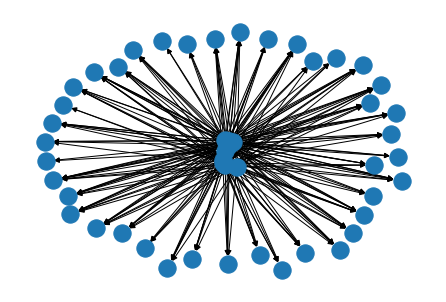

In [48]:
not_filterd_graph = random_graph(10, min_deg_out=30, max_deg_out=50,rnd_range=50)
nx.draw(nx.DiGraph(not_filterd_graph))

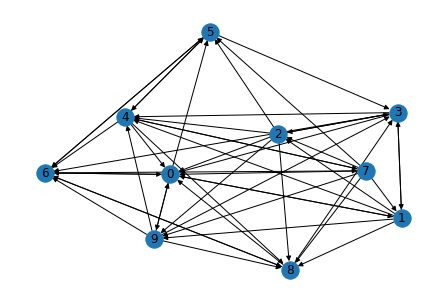

In [49]:
filtered_graph = filter_graph(not_filterd_graph)
nx.draw(nx.DiGraph(filtered_graph), with_labels=True)

## The algoritm:

<b>rwr:</b> random walk with restart. gets graph and source nodes and returns a list containing the most related node to the source nodes (index 0) to the most unrelated node (last index).

In [50]:
def rwr(graph: dict, source_nodes:list, walks=10_000,  probability=0.7):
    node = random.choice(source_nodes)
    nodes_ranking = {node: 0 for node in graph}
    for i in range(walks):
        if node not in graph:
            node = random.choice(source_nodes)
        elif len(graph[node]) == 0:
            node = random.choice(source_nodes)
        elif random.random() < probability:
            node = random.choice(graph[node])
            nodes_ranking[node] += 1
        else:
            node = random.choice(source_nodes)
    return list(filter(lambda x: x not in source_nodes,list(bubble_sort_dict((nodes_ranking)).keys()))) 

<b>find_community:</b> gets graph, wanted community size and source_nodes. return the community

In [51]:
def find_community(graph: dict, source_nodes, community_size:int):
    nodes = source_nodes
    for i in range(community_size):
        nodes.append(rwr(graph, nodes)[0])
    return nodes

## results

In [53]:
numpy_filterd_graph = filter_graph(numpy_wiki_graph)

In [59]:
find_community(numpy_filterd_graph, ['numpy'], 10)

['numpy',
 'C (programming language)',
 'Python (programming language)',
 'Open-source software',
 'GitHub',
 'Repository (version control)',
 'Software release life cycle',
 'Software license',
 'Operating system',
 'Programming language',
 'Compiler']

We can see that most of the community members are really related to numpy.

<b>find_page_community:</b> gets a page, community size and returns community 

In [62]:
def find_page_community(page, community_size):
    wikipedia_graph_csv(page, f'{page}.csv')
    page_graph_dict = csv_to_dict(f'{page}.csv')
    page_graph_dict = filter_graph(page_graph_dict)
    return find_community(page_graph_dict, [page], community_size)

In [61]:
find_page_community('matplotlib', 20)

['matplotlib',
 'Software license',
 'Source code',
 'GitHub',
 'Python (programming language)',
 'Object-oriented programming',
 'Software release life cycle',
 'Procedural programming',
 'MATLAB',
 'Programmer',
 'Repository (version control)',
 'Operating system',
 'Qt (software)',
 'API',
 'Software categories',
 'OpenGL',
 'Statsmodels',
 'SciPy',
 'Scikit-learn',
 'Microsoft Excel',
 'NumPy']

In [63]:
rnd_graph_list = random_graph(20)

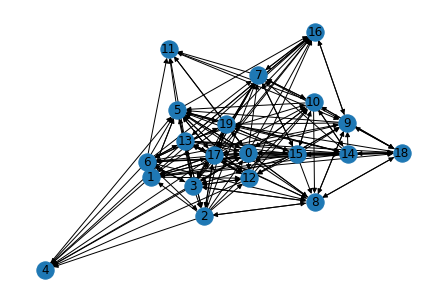

In [65]:
nx.draw(nx.DiGraph(rnd_graph_list), with_labels=True)

In [124]:
find_community(rnd_graph_list, [random.randint(0, 20)], 5)

[4, 5, 0, 16, 9, 7]